## Lab 1.3 - Predicting Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. In this Lab you'll learn how to apply machine learning algorithms to solve business problems. Accurate price prediction can help to find fraudsters automatically and help Yandex.Realty users to make better decisions when buying and selling real estate.

Using python with machine learning algotithms is the #1 option for prototyping solutions among data scientists today. We'll take a look at it in this lab.

### Main objectives
After successful completion of the lab work students will be able to:
-	Apply machine learning for solving price prediction problem
-   Calculate metrics which can help us find out whether our machine learning model is ready for production

### Tasks
-	Encode dataset
-	Split dataset to train and validation datasets
-	Apply decision tree algorithm to build ML (machine learning) model for price predictions
-   Calculate metrics
-   Try other algorithms and factors to get a better solution 


**I have extensively used some pieces of code from the lab example with a few comments**

### 1. Load data with real estate prices

In [2]:
pip install sklearn-pandas

  Using cached sklearn_pandas-2.2.0-py2.py3-none-any.whl (10 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# let's import pandas library and set options to be able to view data right in the browser
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
import numpy as np
import joblib

from matplotlib import pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')

In [4]:
# Calculating the metrics
def calculating_the_metrics(y, y_p):
    rmse = mean_squared_error(y_true=y, y_pred=y_p, squared=False)
    mse = mean_squared_error(y_true=y, y_pred=y_p, squared=True)
    mae = mean_absolute_error(y_true=y, y_pred=y_p)
    return (rmse, mse, mae)

In [5]:
def print_the_metrics(df_type, rmse, mse, mae):
        print(str(df_type) + 'RMSE: %.2f' % rmse)
        print(str(df_type) + 'MSE: %.2f' % mse)
        print(str(df_type) + 'MAE: %.2f' % mae)

In [19]:
# need to check the path to the file before loading. Let me note that this dataset is a little bit different from the one in the 
# lab for the yet unknown reason. Still, the numbers of the datasets are approximately the same.
rent_df_cleaned = pd.read_table('/home/jovyan/materials/spb.real.estate.archive.rent_cleaned_spb.tsv')

In [20]:
rent_df_cleaned.head(1)

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id,price_per_sq_m,house_price_sqm_median
0,1100202,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,False,1,False,28.0,8.0,20.0,100.0,3.0,2,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,714.285714,512.820513


In [10]:
# let's check which other variables we have
rent_df_cleaned[['last_price', 'open_plan', 'rooms', 'area', 'kitchen_area', 'living_area', 'renovation']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155890 entries, 0 to 155889
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   last_price    155890 non-null  float64
 1   open_plan     155890 non-null  bool   
 2   rooms         155890 non-null  int64  
 3   area          155890 non-null  float64
 4   kitchen_area  118764 non-null  float64
 5   living_area   123431 non-null  float64
 6   renovation    102998 non-null  float64
dtypes: bool(1), float64(5), int64(1)
memory usage: 7.3 MB


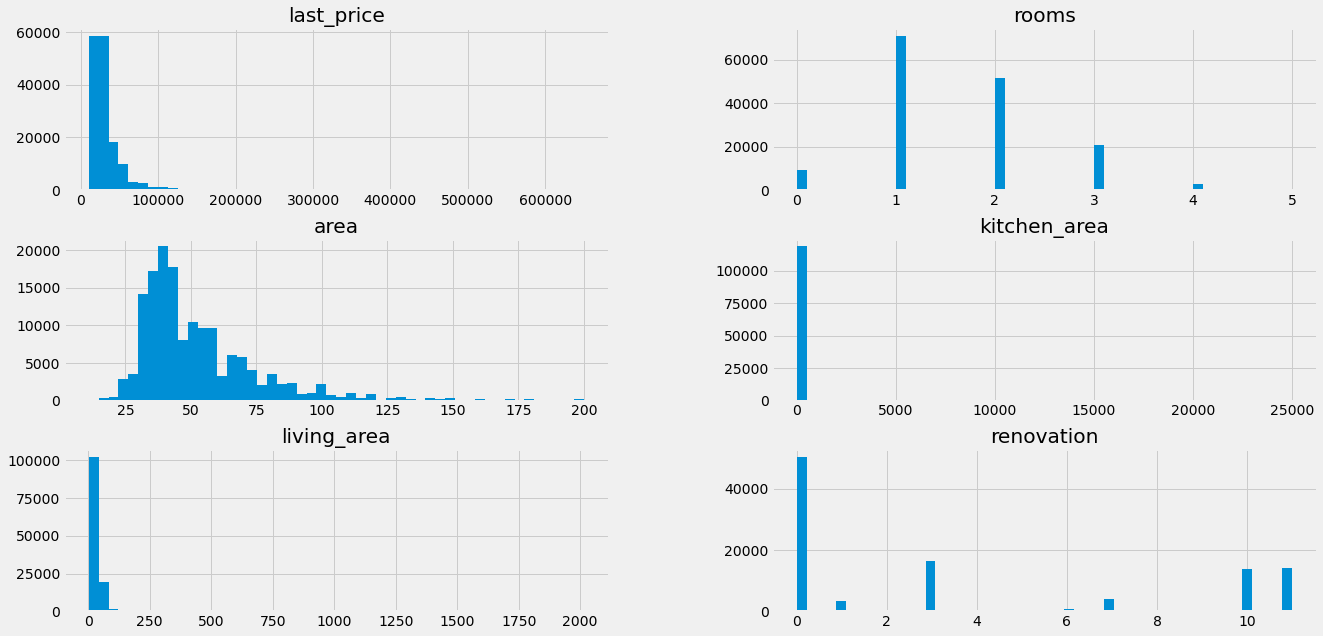

In [11]:
# creating the list of variables we will use in the model
variables = ['last_price', 'rooms', 'area', 'kitchen_area', 'living_area', 'renovation']

rent_df_cleaned[variables].hist(bins=50, figsize=(20,10))

plt.savefig('hist_quant.jpg')

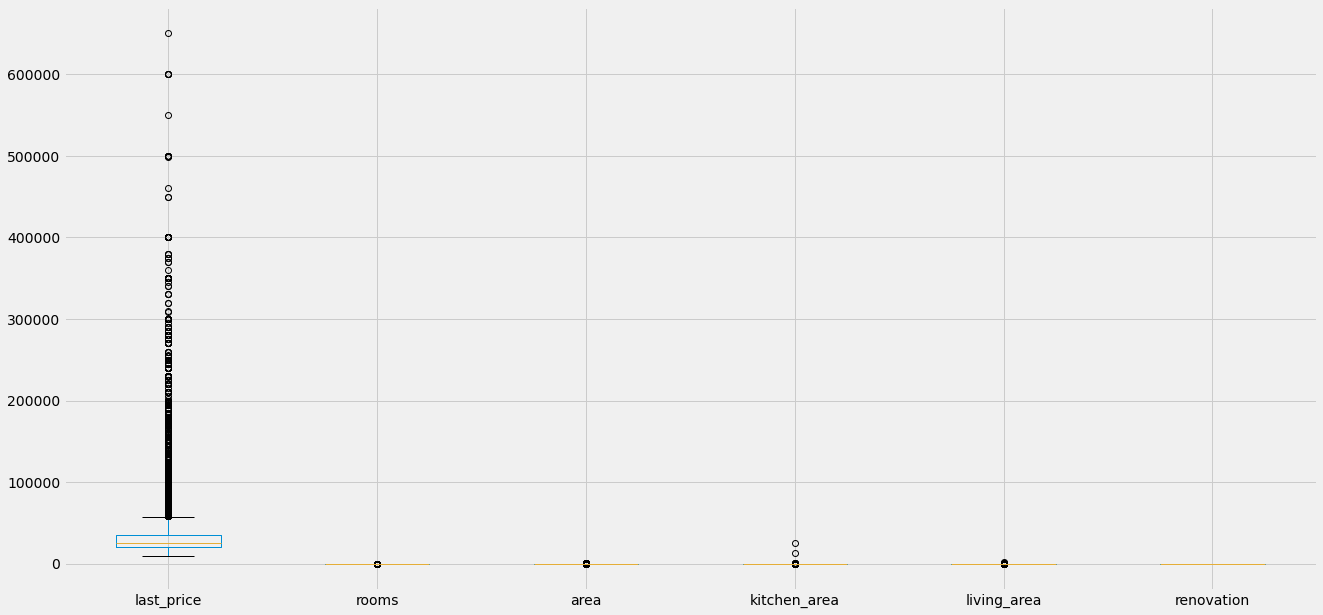

In [12]:
rent_df_cleaned[variables].boxplot(figsize=(20,10));

plt.savefig('box_plot1.jpg')

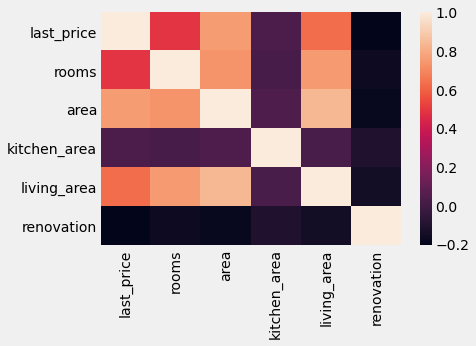

In [52]:
# corr matrix for numeric feauters with price as the last element in the row
sns.heatmap(rent_df_cleaned[variables].corr());

plt.savefig('heat_map.png')

In [14]:
variables2 = ['floor','open_plan','rooms','renovation']

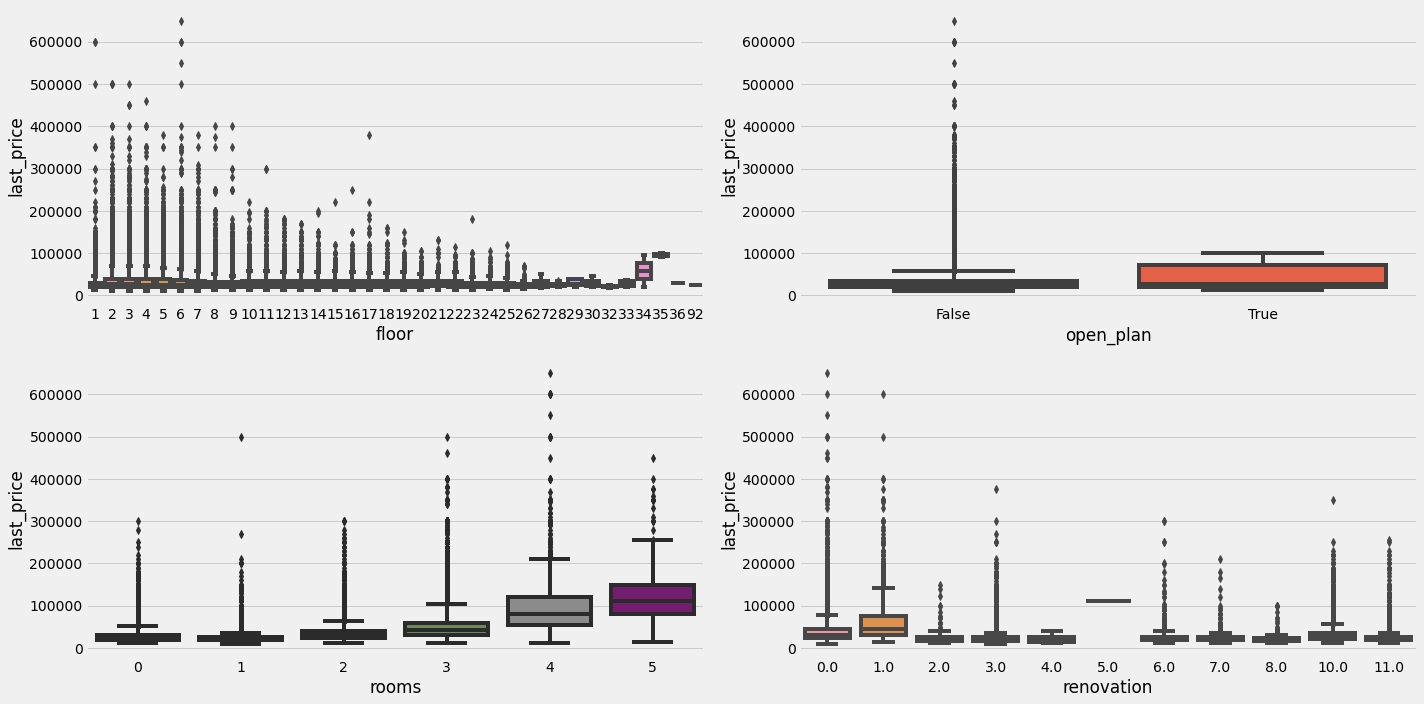

In [15]:
# from the lab
fig, axes = plt.subplots(nrows=2,ncols=2, figsize = (20,10))
for idx, feat in enumerate(variables2):
    ax = axes[int(idx/2),idx%2]
    sns.boxplot(x=feat, y='last_price', data=rent_df_cleaned, ax=ax)
    ax.set_xlabel(feat)
fig.tight_layout()
fig.savefig('box_plot2.jpg')

### 2. Splitting & transforming the data

In [16]:
# fixing types an nulls

rent_df_cleaned['open_plan'] = rent_df_cleaned['open_plan'].astype('int')

rent_df_cleaned['renovation'] = rent_df_cleaned['renovation'].fillna(0)
rent_df_cleaned['living_area'] = rent_df_cleaned['living_area'].fillna(0)
rent_df_cleaned['kitchen_area'] = rent_df_cleaned['kitchen_area'].fillna(0)

rent_df_cleaned['renovation'] = rent_df_cleaned['renovation'].astype('int')

In [18]:
rent_df_cleaned[['last_price', 'open_plan', 'rooms', 'area', 'kitchen_area', 'living_area', 'renovation']].describe()

,last_price,open_plan,rooms,area,kitchen_area,living_area,renovation
count,155890.000000,155890.000000,155890.000000,155890.000000,155890.000000,155890.000000,155890.000000
mean,32605.087190,0.000051,1.605254,53.689242,8.878499,24.239065,2.437411
std,24222.215923,0.007164,0.878990,24.818643,71.845462,20.105232,4.044053
min,9990.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000
25%,20000.000000,0.000000,1.000000,38.000000,5.000000,16.000000,0.000000
50%,25000.000000,0.000000,1.000000,46.000000,9.000000,20.000000,0.000000
75%,35000.000000,0.000000,2.000000,62.000000,12.000000,34.000000,3.000000
max,650000.000000,1.000000,5.000000,200.000000,25000.000000,2015.000000,11.000000


In [56]:
# dividing into train, test and hold-out 
train_df = rent_df_cleaned[(rent_df_cleaned.first_day_exposition >= '2018-01-01') 
                          & (rent_df_cleaned.first_day_exposition < '2018-04-01')]

test_df = rent_df_cleaned[(rent_df_cleaned.first_day_exposition >= '2018-04-01') 
                          & (rent_df_cleaned.first_day_exposition < '2018-06-01')]

holdout_df = rent_df_cleaned[rent_df_cleaned.first_day_exposition >= '2018-06-01']

In [57]:
# creating standard scalers
sc_y = StandardScaler()
sc_x = StandardScaler()

In [58]:
# creating the list of variables we will use in the model
variables = ['last_price', 'open_plan', 'rooms', 'area', 'kitchen_area', 'living_area', 'renovation']

In [59]:
# the usage of a formatter, functions, and global vars causes some complications later with Flask
# in reverse transforming, so we will avoid using them for now

# creating empty datasets/series
y_train = pd.DataFrame(dtype='float64')
X_train = pd.DataFrame()
y_test = pd.DataFrame(dtype='float64')
X_test = pd.DataFrame()

# applying scalars. we will not use scaling for open_plan since it is a binary variable. Maybe we also should not use it 
# for renovation, but let it be for now...

for var in variables:
    if var == 'last_price':
        y_train[var] = sc_y.fit_transform(train_df[var].values.reshape(-1, 1)).flatten()
        y_test[var] = sc_y.fit_transform(test_df[var].values.reshape(-1, 1)).flatten()
    elif var == 'open_plan':
        X_train[var] = train_df[var].values.reshape(-1, 1).flatten()
        X_test[var] = test_df[var].values.reshape(-1, 1).flatten()
    else:
        X_train[var] = sc_x.fit_transform(train_df[var].values.reshape(-1, 1)).flatten()
        X_test[var] = sc_x.fit_transform(test_df[var].values.reshape(-1, 1)).flatten()

In [60]:
X_train.head()

,open_plan,rooms,area,kitchen_area,living_area,renovation
0,0,-0.571269,-0.601119,-0.637516,-1.108984,-0.641025
1,0,-0.571269,-0.793495,-0.030875,-0.082134,-0.405288
2,0,-0.571269,-0.504932,0.055788,-0.082134,-0.641025
3,0,-0.571269,-0.793495,-0.637516,-1.108984,-0.641025
4,0,-0.571269,-0.793495,-0.030875,0.031960,-0.641025


In [61]:
y_train.head()

,last_price
0,-0.096886
1,-0.531115
2,-0.607744
3,-0.301229
4,-0.403401


### Building Decision Tree model

In [108]:
# for the sake of experiment, let's try to apply gridsearch with DecisionTreeRegressor
params = {'tree__min_samples_split': [2, 3],
          'tree__max_depth': [i for i in range(3, 11)],
          'tree__min_samples_leaf': [1, 5, 10],
          'tree__max_features': ['sqrt', None]
         }

dt = Pipeline([('tree', DecisionTreeRegressor(random_state=0))])


dt_cv = GridSearchCV(estimator=dt, param_grid=params, scoring='neg_root_mean_squared_error', cv=5, refit=True, 
                     n_jobs=1,
                     verbose=1)

dt_cv.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree',
                                        DecisionTreeRegressor(random_state=0))]),
             n_jobs=1,
             param_grid={'tree__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'tree__max_features': ['sqrt', None],
                         'tree__min_samples_leaf': [1, 5, 10],
                         'tree__min_samples_split': [2, 3]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [109]:
pd.DataFrame(dt_cv.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(5)

,params,mean_test_score,std_test_score,rank_test_score
22,"{'tree__max_depth': 4, 'tree__max_features': None, 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 2}",-0.674266,0.064511,1
23,"{'tree__max_depth': 4, 'tree__max_features': None, 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 3}",-0.674266,0.064511,1
89,"{'tree__max_depth': 10, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 3}",-0.676073,0.059054,3
88,"{'tree__max_depth': 10, 'tree__max_features': 'sqrt', 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 2}",-0.676073,0.059054,3
10,"{'tree__max_depth': 3, 'tree__max_features': None, 'tree__min_samples_leaf': 10, 'tree__min_samples_split': 2}",-0.678443,0.061017,5


In [110]:
# evaluating the tree with the "best" parameters accoding to the results of GridSearch
tree = DecisionTreeRegressor(max_depth=4, random_state=0, max_features=None, min_samples_leaf=10, min_samples_split=2)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, random_state=0)

In [112]:
# before checking the metrics we will compare a few observations: y_pred and y (as in the example). We will use an X_valid for 
# predictions (which is logical :). Code is from the lab
tree_predictions = tree.predict(X_test)
tree_predictions[:5]

predictions = sc_y.inverse_transform(tree_predictions[:5])
values = test_df['last_price']

for pred, val in zip(predictions, values):
    print("Prediction: {}, True Value {}".format(round(pred, 2), round(val, 2)))

Prediction: 20195.71, True Value 19000.0
Prediction: 29012.83, True Value 29000.0
Prediction: 51530.48, True Value 45000.0
Prediction: 29012.83, True Value 35000.0
Prediction: 29012.83, True Value 35000.0


**We see that the values are more or less close to each other for this restricted sample, but def. not perfect.**

In [113]:
# If you want to see RMSE, MSE ... in real numbers, you need to apply sc_y.inverse_transform(y_train), sc_y.inverse_transform(tree_predictions_train)
# But it is hard to compare, so we will not do it here.
tree_predictions_train = tree.predict(X_train)

rmse, mse, mae = calculating_the_metrics(y_train, tree_predictions_train)
print_the_metrics('Train sample ', rmse, mse, mae)

Train sample RMSE: 0.64
Train sample MSE: 0.41
Train sample MAE: 0.33


In [114]:
rmse, mse, mae = calculating_the_metrics(y_test, tree_predictions)
print_the_metrics('Validation sample ', rmse, mse, mae)

Validation sample RMSE: 0.66
Validation sample MSE: 0.44
Validation sample MAE: 0.32


**The value is slightly worse on the validation sample, so probably there is some degree of overfitting..**

### Random Forest Regressor model

In [115]:
# for random forest recommended number of max_features is calculated like max_features = d/3
len(X_train.columns)/3

# so, approximately 2..

2.0

In [127]:
# Let's try to apply gridsearch with RandomForestRegressor
params = {'forest__n_estimators': [10, 100, 200],
          'forest__max_depth': [i for i in range(5, 36, 5)],
          'forest__min_samples_leaf': [1, 3, 10],
          'forest__max_features': [2, 1],
          'forest__min_samples_split' : [2, 3]
         }

rt = Pipeline([('forest', RandomForestRegressor(random_state=0, bootstrap=True))])


rt_cv = GridSearchCV(estimator=rt, param_grid=params, scoring='neg_root_mean_squared_error', cv=5, refit=True, 
                     n_jobs=1,
                     verbose=2)

rt_cv.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.3s
[CV] 

[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.3s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.3s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.6s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.6s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.6s
[CV] END forest__max_depth=5, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.6s
[CV] END forest__max_depth=5, forest__max_features=2, forest__mi

[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.2s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.2s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.2s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.2s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.2s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.5s
[CV] END forest__max_depth=5, forest__max_features=1, forest__mi

[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   0.5s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   0.4s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=5, forest__max_features=1, forest__

[CV] END forest__max_depth=10, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=10, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=10, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=10, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=10, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=200; total time=   0.9s
[CV] END forest__max_depth=10, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=200; total time=   0.9s
[CV] END forest__max_depth=10, forest__max_features=2, for

[CV] END forest__max_depth=10, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.9s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=10, forest__max_features=1, forest_

[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.3s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.7s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.7s
[CV] END forest__max_depth=10, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.7s
[CV] END forest__max_depth=10, forest__max_features=1, for

[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=15, forest__max_features=2, forest

[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=15, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=15, forest__max_features=2

[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=15, forest__max_features=1, fore

[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.8s
[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.8s
[CV] END forest__max_depth=15, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.8s
[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=20, forest__max_features=2, for

[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=20, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=200; total time=   1.2s
[CV] END forest__max_depth=20, forest__max_features=2, for

[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.3s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.3s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=20, forest__max_features=1, forest_

[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   0.8s
[CV] END forest__max_depth=20, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   0.8s
[CV] END forest__max_depth=20, forest__max_features=

[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=200; total time=   1.6s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=25, forest__max_features=2, forest__

[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=25, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=25, forest__max_features=

[CV] END forest__max_depth=25, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=25, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=25, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=25, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=25, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=25, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=25, forest__max_features=1, fores

[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.7s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.7s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.7s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.7s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=30, forest__max_features=2, fores

[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.6s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.5s
[CV] END forest__max_depth=30, forest__max_features=2, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.0s
[CV] END forest__max_depth=30, forest__max_features=

[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=200; total time=   1.4s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=3, forest__n_estimators=200; total time=   1.4s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=30, forest__max_features=1, forest_

[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.8s
[CV] END forest__max_depth=30, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=3, forest__n_estimators=200; total time=   0.8s
[CV] END forest__max_depth=30, forest__max_features=

[CV] END forest__max_depth=35, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.2s
[CV] END forest__max_depth=35, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=35, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=35, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=35, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=35, forest__max_features=2, forest__min_samples_leaf=3, forest__min_samples_split=3, forest__n_estimators=10; total time=   0.1s
[CV] END forest__max_depth=35, forest__max_features=2, forest__

[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.7s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.7s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.7s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.5s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.5s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=1, forest__min_samples_split=2, forest__n_estimators=200; total time=   1.5s
[CV] END forest__max_depth=35, forest__max_features=1, for

[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=10; total time=   0.0s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=35, forest__max_features=1, forest__min_samples_leaf=10, forest__min_samples_split=2, forest__n_estimators=100; total time=   0.4s
[CV] END forest__max_depth=35, forest__max_features=1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=1,
             param_grid={'forest__max_depth': [5, 10, 15, 20, 25, 30, 35],
                         'forest__max_features': [2, 1],
                         'forest__min_samples_leaf': [1, 3, 10],
                         'forest__min_samples_split': [2, 3],
                         'forest__n_estimators': [10, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [128]:
pd.DataFrame(rt_cv.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(5)

,params,mean_test_score,std_test_score,rank_test_score
61,"{'forest__max_depth': 10, 'forest__max_features': 1, 'forest__min_samples_leaf': 3, 'forest__min_samples_split': 2, 'forest__n_estimators': 100}",-0.633108,0.051192,1
64,"{'forest__max_depth': 10, 'forest__max_features': 1, 'forest__min_samples_leaf': 3, 'forest__min_samples_split': 3, 'forest__n_estimators': 100}",-0.633108,0.051192,1
122,"{'forest__max_depth': 20, 'forest__max_features': 2, 'forest__min_samples_leaf': 10, 'forest__min_samples_split': 2, 'forest__n_estimators': 200}",-0.633466,0.050477,3
125,"{'forest__max_depth': 20, 'forest__max_features': 2, 'forest__min_samples_leaf': 10, 'forest__min_samples_split': 3, 'forest__n_estimators': 200}",-0.633466,0.050477,3
53,"{'forest__max_depth': 10, 'forest__max_features': 2, 'forest__min_samples_leaf': 10, 'forest__min_samples_split': 3, 'forest__n_estimators': 200}",-0.633498,0.050837,5


In [129]:
# evaluating the random forest with the "best" parameters according to the results of GridSearch
forest = RandomForestRegressor(max_depth=10, random_state=0, max_features=1, min_samples_leaf=3, min_samples_split=2,
                              n_estimators=100)
forest.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=10, max_features=1, min_samples_leaf=3,
                      random_state=0)

In [130]:
# Let's have a look at some of the values this time
forest_predictions = forest.predict(X_test)
forest_predictions[:5]

predictions = sc_y.inverse_transform(forest_predictions[:5])
values = test_df['last_price']

for pred, val in zip(predictions, values):
    print("Prediction: {}, True Value {}".format(round(pred, 2), round(val, 2)))

Prediction: 19111.13, True Value 19000.0
Prediction: 27777.79, True Value 29000.0
Prediction: 58398.0, True Value 45000.0
Prediction: 29153.54, True Value 35000.0
Prediction: 29564.82, True Value 35000.0


I would say that on the first glance it is worse than before, well, at least with this sample :D

In [131]:
forest_predictions_train = forest.predict(X_train)

rmse, mse, mae = calculating_the_metrics(y_train, forest_predictions_train)
print_the_metrics('Train sample ', rmse, mse, mae)

Train sample RMSE: 0.54
Train sample MSE: 0.29
Train sample MAE: 0.28


In [133]:
rmse, mse, mae = calculating_the_metrics(y_test, forest_predictions)
print_the_metrics('Validation sample ', rmse, mse, mae)

Validation sample RMSE: 0.64
Validation sample MSE: 0.41
Validation sample MAE: 0.31


**Some overfitting is defenitely presented.**

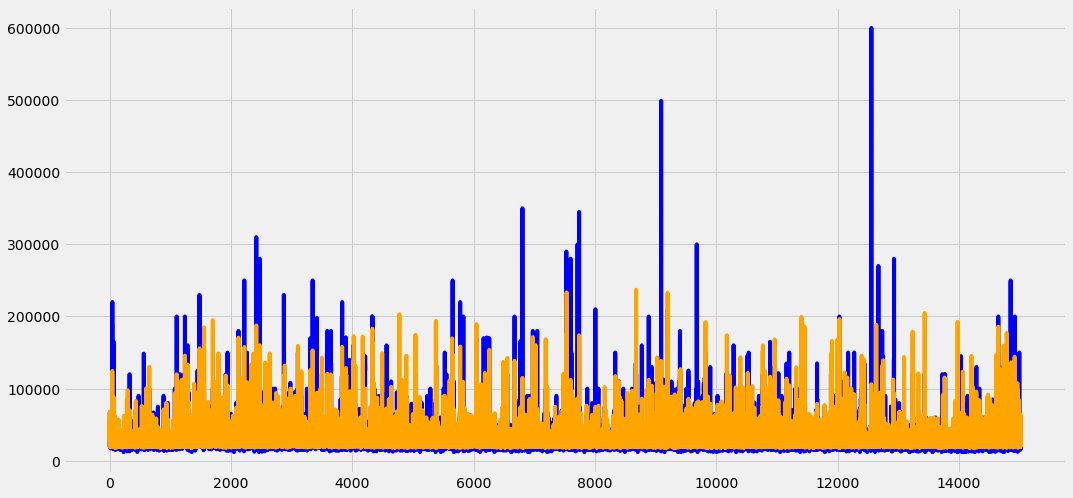

In [134]:
# comparing predictions with real numbers with the usage of visualization tools...
plt.figure(figsize=(16,8))
plt.plot(sc_y.inverse_transform(y_test), label ='Test', color= 'blue')
plt.plot(sc_y.inverse_transform(forest_predictions), label = 'predict', color = 'orange')
plt.show()

### Cat Boost Regressor model

In [136]:
# Let's try to apply Gridsearch with CatBoost Regressor
params = {'catboost__iterations': [1500, 2500],
          'catboost__depth': [i for i in range(6, 11, 2)],
          'catboost__learning_rate': [i for i in np.arange(0.03, 0.10, 0.03)]
         }

cb = Pipeline([('catboost', CatBoostRegressor(random_seed=1234, logging_level='Silent', thread_count=10))])


cb_cv = GridSearchCV(estimator=cb, param_grid=params, scoring='neg_root_mean_squared_error', cv=5, refit=True, 
                     n_jobs=1,
                     verbose=2)

cb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.03; total time=   4.6s
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.03; total time=   4.8s
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.03; total time=   4.5s
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.03; total time=   4.6s
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.03; total time=   4.8s
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.06; total time=   4.6s
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.06; total time=   4.7s
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.06; total time=   4.8s
[CV] END catboost__depth=6, catboost__iterations=1500, catboost__learning_rate=0.06; total time=   4.8s
[CV

[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.03; total time=  19.0s
[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.06; total time=  18.9s
[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.06; total time=  19.0s
[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.06; total time=  19.3s
[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.06; total time=  18.7s
[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.06; total time=  18.7s
[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.09; total time=  18.9s
[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.09; total time=  19.1s
[CV] END catboost__depth=10, catboost__iterations=2500, catboost__learning_rate=0.09; total time=  19.0s
[CV] END catboost__depth=10, catboost__iterations=2500,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('catboost',
                                        <catboost.core.CatBoostRegressor object at 0x7fb8b15af400>)]),
             n_jobs=1,
             param_grid={'catboost__depth': [6, 8, 10],
                         'catboost__iterations': [1500, 2500],
                         'catboost__learning_rate': [0.03, 0.06, 0.09]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [138]:
pd.DataFrame(cb_cv.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(5)

,params,mean_test_score,std_test_score,rank_test_score
6,"{'catboost__depth': 8, 'catboost__iterations': 1500, 'catboost__learning_rate': 0.03}",-0.653081,0.064091,1
12,"{'catboost__depth': 10, 'catboost__iterations': 1500, 'catboost__learning_rate': 0.03}",-0.654854,0.059377,2
9,"{'catboost__depth': 8, 'catboost__iterations': 2500, 'catboost__learning_rate': 0.03}",-0.659116,0.063938,3
7,"{'catboost__depth': 8, 'catboost__iterations': 1500, 'catboost__learning_rate': 0.06}",-0.659324,0.062568,4
15,"{'catboost__depth': 10, 'catboost__iterations': 2500, 'catboost__learning_rate': 0.03}",-0.661877,0.059368,5


In [139]:
# evaluating the catboost with the "best" parameters according to the results of GridSearch
catboost_model = CatBoostRegressor(iterations=1500, 
                                 depth=8,
                                 learning_rate=0.03,
                                 logging_level='Silent',
                                 thread_count=10,
                                 random_seed=1234)
catboost_model.fit(X_train, y_train)

In [140]:
catboost_predictions_train = catboost_model.predict(X_train)

rmse, mse, mae = calculating_the_metrics(y_train, catboost_predictions_train)
print_the_metrics('Train sample ', rmse, mse, mae)

Train sample RMSE: 0.41
Train sample MSE: 0.16
Train sample MAE: 0.26


In [143]:
catboost_predictions = catboost_model.predict(X_test)

rmse, mse, mae = calculating_the_metrics(y_test, catboost_predictions)
print_the_metrics('Validation sample ', rmse, mse, mae)

Validation sample RMSE: 0.70
Validation sample MSE: 0.49
Validation sample MAE: 0.32


**Overfitting? The results on train are much better than for random forest and decision tree regressors, but they got noticably worse on the validation set.**

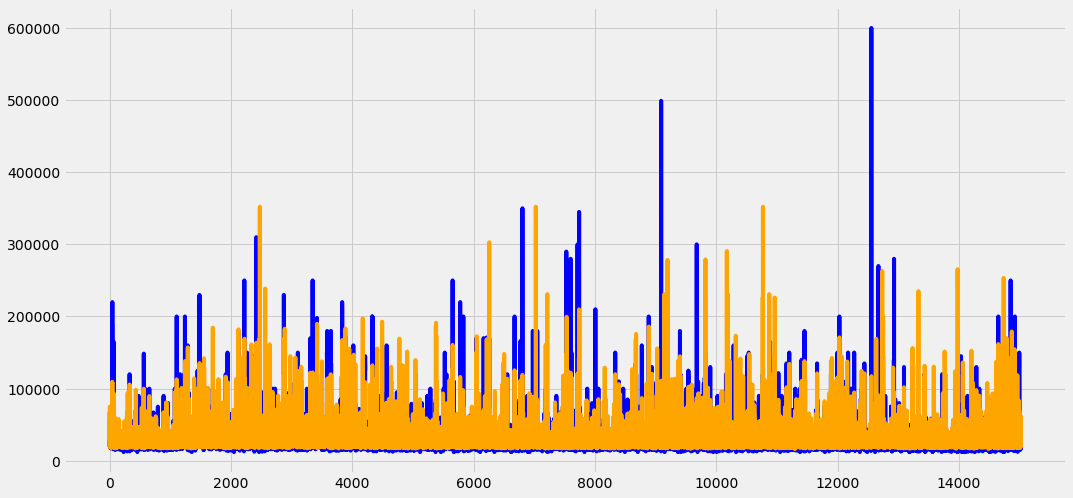

In [144]:
plt.figure(figsize=(16,8))
plt.plot(sc_y.inverse_transform(y_test), label ='Test', color= 'blue')
plt.plot(sc_y.inverse_transform(catboost_predictions), label = 'predict', color = 'orange')
plt.show()

### Save the models and the scalers as a pipeline

In [18]:
# At first, I will recreate the scalers to apply them later on the whole dataset
sc_x = StandardScaler()
sc_y = StandardScaler()

var_x = ['open_plan', 'rooms', 'area', 'kitchen_area', 'living_area', 'renovation']

In [26]:
X_train = sc_x.fit_transform(train_df[var_x])
y_train = sc_y.fit_transform(train_df['last_price'].values.reshape(-1,1))

In [32]:
# evaluating the random forest with the "best" parameters according to the results of GridSearch
forest = RandomForestRegressor(max_depth=10, random_state=0, max_features=1, min_samples_leaf=3, min_samples_split=2,
                              n_estimators=100)
forest.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=10, max_features=1, min_samples_leaf=3,
                      random_state=0)

The first model I will extract is a random forest model:

In [33]:
rf_model_file = 'rf_model.pkl'
scaler_x = 'scaler_x.pkl'
scaler_y = 'scaler_y.pkl'
joblib.dump(sc_x, scaler_x)
joblib.dump(sc_y, scaler_y)
joblib.dump(forest, rf_model_file)

['rf_model.pkl']

The second model I will extract is a catboost model:

In [34]:
# evaluating the catboost with the "best" parameters according to the results of GridSearch
catboost_model = CatBoostRegressor(iterations=1500, 
                                 depth=8,
                                 learning_rate=0.03,
                                 logging_level='Silent',
                                 thread_count=10,
                                 random_seed=1234)
catboost_model.fit(X_train, y_train)

In [35]:
cb_model_file = 'cb_model.pkl'
joblib.dump(catboost_model, cb_model_file)

['cb_model.pkl']

### Self-control stops
1. Compete with other teams to create the best solution. You can play with factors and algorithm parameters to come up with it.

If it is possible, I will be interested in reading through others' decisions, because probably they might have successfully applied other regressors I do not have experience with (maybe something like XGboost...) or used different parameters or maybe did something with the samples... 